In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from models.activation.exu import ExU
from models.activation.relu import LinearReLU
from models.featurenn import FeatureNN
from models.dnn import DNN
from models.nam import NAM
from config.default import defaults
from trainer.losses import *
from trainer.metrics import *
from trainer.trainer import Trainer
from data.toydataset import ToyDataset
from data.generator import *

2023-07-05 09:54:15.200918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%reload_ext autoreload 
%autoreload 2

In [3]:
def test_LinearReLU_shape():
    print("===Standard ReLU test===")
    n_inputs = 5 
    n_outputs = 3
    relu = LinearReLU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    y = relu(inputs)
    assert len(y) == n_outputs, f"Wrong output length: {len(y)}"
    print(f"inputs: {inputs}, \noutputs: {y}")
    
def test_ExU_shape():
    # TODO
    print("===ExU test===")
    n_inputs = 5 
    n_outputs = 3
    exu = ExU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    y = exu(inputs, 1)
    assert len(y) == n_outputs, f"Wrong output length: {len(y)}"
    print(f"inputs: {inputs}, \noutputs: {y}")
    
test_LinearReLU_shape()
test_ExU_shape()

===Standard ReLU test===
inputs: tensor([-0.7709, -0.1660, -0.1601,  1.0862,  0.8160]), 
outputs: tensor([0.5866, 0.0000, 0.0000], grad_fn=<ReluBackward0>)
===ExU test===
inputs: tensor([ 1.0646,  0.6012, -0.7617,  0.8958,  0.7550]), 
outputs: tensor([1., 1., 1.], grad_fn=<ClampBackward1>)


In [4]:
def test_featureNN_shape():
    print("===Feature neural net test===")
    cfg = defaults()
    cfg.hidden_sizes = [64, 64, 32]
    print(cfg)
    name = "featureNN test"
    in_features = 1
    batch_size = 5 
    num_units = 32
    feature_index = 1
    fnn = FeatureNN(cfg, name, in_features, num_units, feature_index)
    print(fnn)
    
    inputs = torch.rand(batch_size)
    print(inputs)
    outputs = fnn(inputs)
    print(outputs)
    assert outputs.shape == (batch_size, 1), f"Wrong output shape: {outputs.shape}"
    
    
test_featureNN_shape()    

===Feature neural net test===
Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.001, l2_regularization=0, output_regularization=0, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 64, 32], activation='exu')
FeatureNN(
  (model): Sequential(
    (0): ExU(in_features=1, out_features=32)
    (1): Dropout(p=0, inplace=False)
    (2): LinearReLU(in_features=32, out_features=64)
    (3): Dropout(p=0, inplace=False)
    (4): LinearReLU(in_features=64, out_features=64)
    (5): Dropout(p=0, inplace=False)
    (6): LinearReLU(in_features=64, out_features=32)
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Dropout(p=0, inplace=False)
  )
)
tensor([0.4659, 0.2653, 0.3395, 0.3779, 0.2242])
tensor([[-0.5573],
        [-0.4508],
        [-0.4773],
        [-0.5704],
        [-0.4508]],

In [6]:
def test_DNN_shape():
    print("===DNN baseline test===")
    cfg = defaults()
    cfg.hidden_sizes = [64, 64, 32]
    print(cfg)
    batch_size = 5 
    dnn = DNN(cfg)
    
    inputs = torch.rand(batch_size, 1)
    print(inputs)
    outputs, fnn_outs = dnn(inputs)
    print(outputs)
    assert outputs.shape == (batch_size, 1), f"Wrong output shape: {outputs.shape}"
    
test_DNN_shape()    

===DNN baseline test===
Config(device='cpu', seed=2023, experiment_name='NAM', regression=True, num_epochs=100, lr=0.001, batch_size=32, logdir='output', wandb=False, log_loss_frequency=10, hidden_sizes=[64, 64, 32], activation='relu', dropout=0, feature_dropout=0, decay_rate=0, l2_regularization=0, output_regularization=0, num_basis_functions=64, units_multiplier=2, shuffle=True, early_stopping_patience=50, use_dnn=False)
tensor([[0.3677],
        [0.9282],
        [0.5744],
        [0.7715],
        [0.0405]])
tensor([[-0.6458],
        [-1.5712],
        [-0.9870],
        [-1.3125],
        [-0.1080]], grad_fn=<AddmmBackward0>)


Config(device='cpu', seed=2023, experiment_name='NAM', regression=True, num_epochs=100, lr=0.001, batch_size=32, logdir='output', wandb=False, log_loss_frequency=10, hidden_sizes=[64, 32], activation='relu', dropout=0, feature_dropout=0, decay_rate=0, l2_regularization=0, output_regularization=0, num_basis_functions=64, units_multiplier=2, shuffle=True, early_stopping_patience=50, use_dnn=False)


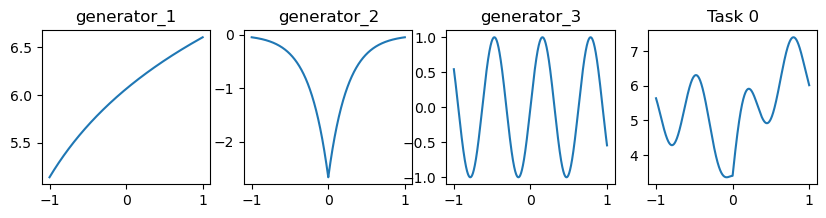

In [7]:
cfg = defaults()
print(cfg)
num_samples = 3000
in_features = 3
x_start, x_end = -1, 1
def init_toydataset(
    task_name: str, 
    cfg, 
    num_samples: int, 
    in_features: int, 
    x_start: float, 
    x_end: float, 
    gen_funcs: Sequence, 
    gen_func_names: Sequence):
    """
    initialize toydataset from a synthetic additive function. 
    input features xj is sampled from a uniform distribution U(-1, 1), 
    with a total of num_samples = 3000 samples.
    
    Args:
    in_features: the number of input features, 
    gen_funcs: the list of input feature generation functions
    gen_func_names: the list of function name
    """
    toydataset = ToyDataset(task_name, cfg, num_samples, in_features, x_start, x_end, gen_funcs, gen_func_names)
    toydataset.plot()
    return toydataset

gen_funcs, gen_func_names = task_0()
toydataset_0 = init_toydataset("Task 0", cfg, num_samples, in_features, x_start, x_end,gen_funcs, gen_func_names)

dataloader_train, dataloader_val, dataloader_test = toydataset_0.get_dataloaders()

In [8]:
def test_NAM_with_toydataset(in_features, dataloader):
    nam = NAM(cfg, "NAM Model", in_features, cfg.num_basis_functions)
    for index, data in enumerate(dataloader): 
        features, targets = data
        print(features.shape)
        outputs, fnn_outputs = nam(features)
        print(f"batch_index: {index}, outputs: {outputs}, fnn_out: {fnn_outputs}")
        if index > 1:
            break
            
test_NAM_with_toydataset(3, dataloader_train)

torch.Size([32, 3])
batch_index: 0, outputs: tensor([0.5478, 0.5566, 0.5388, 0.5407, 0.4104, 0.5395, 0.4467, 0.5219, 0.5210,
        0.4895, 0.5676, 0.4901, 0.5703, 0.4141, 0.4823, 0.5586, 0.4474, 0.5414,
        0.4976, 0.4982, 0.4240, 0.4433, 0.5543, 0.5449, 0.5569, 0.4978, 0.5343,
        0.4974, 0.5438, 0.5288, 0.5536, 0.5442], grad_fn=<AddBackward0>), fnn_out: tensor([[ 0.5381, -0.1305,  0.1402],
        [ 0.5479, -0.1311,  0.1398],
        [ 0.5249, -0.1253,  0.1392],
        [ 0.5280, -0.1269,  0.1396],
        [ 0.4497, -0.1542,  0.1150],
        [ 0.5261, -0.1259,  0.1394],
        [ 0.4581, -0.1397,  0.1283],
        [ 0.4957, -0.1098,  0.1360],
        [ 0.4932, -0.1079,  0.1357],
        [ 0.4779, -0.1212,  0.1328],
        [ 0.5611, -0.1332,  0.1397],
        [ 0.4782, -0.1210,  0.1329],
        [ 0.5640, -0.1336,  0.1398],
        [ 0.4466, -0.1509,  0.1184],
        [ 0.4745, -0.1242,  0.1320],
        [ 0.5498, -0.1314,  0.1402],
        [ 0.4584, -0.1394,  0.1284],
   

In [9]:
def test_NAM_shape(in_features, num_units):
    print("===NAM test===")
    cfg = defaults()
    cfg.hidden_sizes = [64, 64, 32]
    print(cfg)
    batch_size = 5 
    
    inputs = torch.rand(batch_size, in_features)
    print(inputs)
    
    nam = NAM(cfg, "NAM", in_features, num_units)
    outputs, fnn_outputs = nam(inputs)
    assert len(outputs) == batch_size, f"Wrong output length: {len(outputs)}"
    assert fnn_outputs.shape == (batch_size, in_features), f"Wrong fnn output shape: {fnn_outputs.shape}"
    
test_NAM_shape(3, 32)
test_NAM_shape(3, [32, 64, 64])

===NAM test===
Config(device='cpu', seed=2023, experiment_name='NAM', regression=True, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, log_loss_frequency=2, hidden_sizes=[64, 64, 32], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1024, shuffle=True, early_stopping_patience=50)
tensor([[0.6668, 0.5824, 0.3034],
        [0.9986, 0.0746, 0.5786],
        [0.5176, 0.5251, 0.8880],
        [0.7046, 0.3962, 0.3629],
        [0.8853, 0.9296, 0.2668]])
===NAM test===
Config(device='cpu', seed=2023, experiment_name='NAM', regression=True, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, log_loss_frequency=2, hidden_sizes=[64, 64, 32], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1024, shuffle=True, early_stopping_patience=50)
tensor([[0.6464, 0.2681, 0.1523],
       

In [10]:
def test_loss_metrics_pipeline(regression, 
                               batch_size, 
                               in_features, 
                               inputs, 
                               targets):
    print("===penalized loss test===")
    batch_size = len(inputs)
    cfg = defaults()
    cfg.regression = regression
    cfg.hidden_sizes = [64, 64, 32]
    num_units = 64
    
    
    nam = NAM(cfg, "NAM", in_features, num_units)
    out, fnn_out = nam(inputs)
    print(f"prediction: {out}")
    loss = penalized_loss(cfg, out, fnn_out, nam, targets)
    print(f"penalized loss; {loss}")
    
    metrics = lambda o, t: mae(o, t) if cfg.regression else accuracy(o, t)
    metrics_name = "MAE" if cfg.regression else "Accuracy"
        
    print(f"{metrics_name}: {metrics(out, targets)}")
    # assert len(outputs) == batch_size, f"Wrong output length: {len(outputs)}"
    # assert fnn_outputs.shape == (batch_size, in_features), f"Wrong fnn output shape: {fnn_outputs.shape}"


batch_size = 5 
in_features = 1
inputs = torch.rand(batch_size, in_features)
print(inputs)
targets = torch.Tensor([int(x > 0.5) for x in inputs])
print(targets)
# binary classification 
test_loss_metrics_pipeline(False, batch_size, in_features, inputs, targets)

tensor([[0.5223],
        [0.4713],
        [0.2663],
        [0.2946],
        [0.6342]])
tensor([1., 0., 0., 0., 1.])
===penalized loss test===
prediction: tensor([ 0.0243,  0.0678,  0.0000,  0.0000, -0.1207], grad_fn=<AddBackward0>)
penalized loss; 125.67633056640625
Accuracy: 0.6000000238418579


Config(device='cpu', seed=2023, experiment_name='NAM', regression=True, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, log_loss_frequency=2, hidden_sizes=[64, 64, 32], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1024, shuffle=True, early_stopping_patience=50)


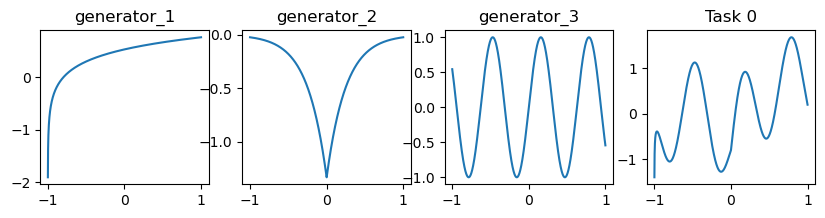

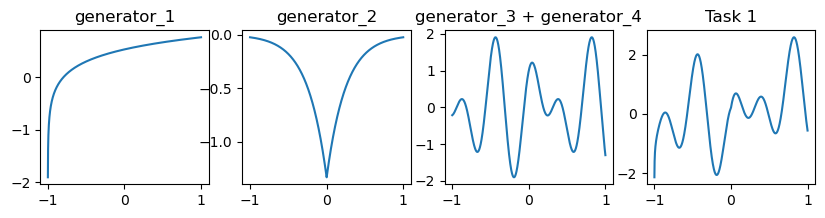

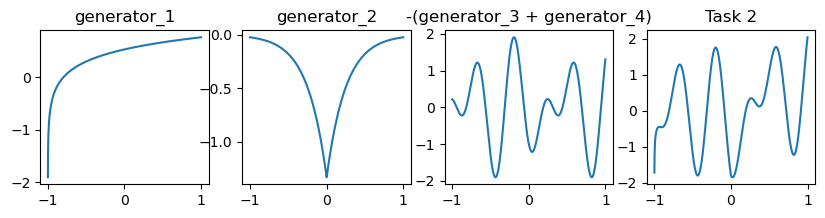

In [11]:
def init_toydataset(
    task_name: str, 
    cfg, 
    num_samples: int, 
    in_features: int, 
    x_start: float, 
    x_end: float, 
    gen_funcs: Sequence, 
    gen_func_names: Sequence):
    """
    initialize toydataset from a synthetic additive function. 
    input features xj is sampled from a uniform distribution U(-1, 1), 
    with a total of num_samples = 3000 samples.
    
    Args:
    in_features: the number of input features, 
    gen_funcs: the list of input feature generation functions
    gen_func_names: the list of function name
    """
    toydataset = ToyDataset(task_name, cfg, num_samples, in_features, x_start, x_end, gen_funcs, gen_func_names)
    toydataset.plot()


cfg = defaults()
print(cfg)
num_samples = 3000
in_features = 3
x_start, x_end = -1, 1
init_toydataset("Task 0", cfg, num_samples, in_features, x_start, x_end, task_0(), ["generator_1", "generator_2", "generator_3"])
init_toydataset("Task 1", cfg, num_samples, in_features, x_start, x_end, task_1(), ["generator_1", "generator_2", "generator_3 + generator_4"])
init_toydataset("Task 2", cfg, num_samples, in_features, x_start, x_end, task_2(), ["generator_1", "generator_2", "-(generator_3 + generator_4)"])

In [12]:
"""feature loss test"""
def test_feature_loss(in_features, batch_size):
    fnn_out = torch.rand(batch_size, in_features)
    def fnn_loss(fnn_out: torch.Tensor)->torch.Tensor:
        num_fnn = len(fnn_out) # number of feature nets
        return torch.mean(torch.square(fnn_out), 1).sum() / num_fnn

    def features_loss(per_feature_outputs: torch.Tensor) -> torch.Tensor:
        per_feature_norm = [  # L2 Regularization
            torch.mean(torch.square(outputs)) for outputs in per_feature_outputs
        ]
        return sum(per_feature_norm) / len(per_feature_norm)    
    
    print(fnn_loss(fnn_out))
    print(features_loss(fnn_out))

batch_size = 5
in_features = 3
test_feature_loss(in_features, batch_size)

tensor(0.2603)
tensor(0.2603)
